<a href="https://colab.research.google.com/github/mjgpinheiro/Physics_models/blob/main/Helium_with_M%C3%B6bius_Boundary_Conditions_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ζ=1.60  Singlet=-92.7088  Triplet(Möbius)=-291.4495
ζ=1.70  Singlet=-101.9930  Triplet(Möbius)=-415.2805
ζ=1.80  Singlet=-120.5176  Triplet(Möbius)=-371.5432
ζ=1.90  Singlet=-170.8236  Triplet(Möbius)=-476.1891
ζ=2.00  Singlet=-169.7798  Triplet(Möbius)=-462.0514
ζ=2.10  Singlet=-165.0316  Triplet(Möbius)=-474.0698
ζ=2.20  Singlet=-189.6044  Triplet(Möbius)=-504.9730


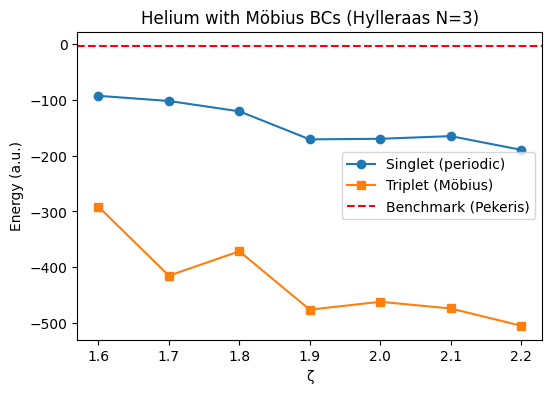


=== Summary Table ===
Singlet min ≈ -189.604400 a.u.
Triplet min ≈ -504.972983 a.u.
Benchmark (Pekeris) = -2.903724 a.u.


In [ ]:
# -*- coding: utf-8 -*-
# Helium with Möbius Boundary Conditions (Final Version)
# Author: M.J.P. (2025)
# Ready for Colab

import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eigh, svd
from numpy.polynomial.laguerre import laggauss

Z = 2.0   # Helium nucleus charge

# =====================================================
# 1. Hylleraas basis (up to N=3)
# =====================================================
def hylleraas_indices(N=3):
    idx=[]
    for i in range(N+1):
        for j in range(N+1-i):
            for k in range(N+1-i-j):
                idx.append((i,j,k))
    return idx

def phi(r1,r2,r12, ijk, zeta, sector):
    i,j,k = ijk
    poly = (r1**i)*(r2**j)*(r12**k)
    env  = np.exp(-zeta*(r1+r2))
    sgn  = 1.0 if sector=="singlet" else np.sign(r1-r2)
    return poly*env*sgn

# =====================================================
# 2. Derivatives of basis (for Laplacian)
# =====================================================
def d_r1(phi,r1,i,zeta):   return phi*((i/(r1+1e-300))-zeta)
def d2_r1(phi,r1,i,zeta):  return phi*((i/(r1+1e-300)-zeta)**2 - i/(r1+1e-300)**2)
def d_r2(phi,r2,j,zeta):   return phi*((j/(r2+1e-300))-zeta)
def d2_r2(phi,r2,j,zeta):  return phi*((j/(r2+1e-300)-zeta)**2 - j/(r2+1e-300)**2)
def d_r12(phi,r12,k):      return phi*(k/(r12+1e-300))
def d2_r12(phi,r12,k):     return phi*(k*(k-1)/(r12+1e-300)**2)
def d2_r1r2(phi,r1,r2,i,j,zeta):   return phi*((i/(r1+1e-300)-zeta)*(j/(r2+1e-300)-zeta))
def d2_r1r12(phi,r1,r12,i,k,zeta): return phi*((i/(r1+1e-300)-zeta)*(k/(r12+1e-300)))
def d2_r2r12(phi,r2,r12,j,k,zeta): return phi*((j/(r2+1e-300)-zeta)*(k/(r12+1e-300)))

def laplacian_on_basis(r1,r2,r12, ijk, zeta, sector):
    i,j,k = ijk
    val = phi(r1,r2,r12,ijk,zeta,sector)
    dr1, d2r1   = d_r1(val,r1,i,zeta), d2_r1(val,r1,i,zeta)
    dr2, d2r2   = d_r2(val,r2,j,zeta), d2_r2(val,r2,j,zeta)
    dr12, d2r12 = d_r12(val,r12,k), d2_r12(val,r12,k)
    d2r1r2   = d2_r1r2(val,r1,r2,i,j,zeta)
    d2r1r12  = d2_r1r12(val,r1,r12,i,k,zeta)
    d2r2r12  = d2_r2r12(val,r2,r12,j,k,zeta)
    A=(r1**2+r2**2-r12**2)/(r1*r2+1e-300)
    B=(r1**2+r12**2-r2**2)/(r1*r12+1e-300)
    C=(r2**2+r12**2-r1**2)/(r2*r12+1e-300)
    lap=(d2r1+d2r2+(2/r1+1e-300)*dr1+(2/r2+1e-300)*dr2
         +2*(d2r12+(2/r12+1e-300)*dr12)
         +A*d2r1r2+B*d2r1r12+C*d2r2r12)
    return lap

# =====================================================
# 3. Quadrature (Gauss–Laguerre)
# =====================================================
def gauss_laguerre(n, scale=1.0):
    x,w=laggauss(n)
    return x/scale, w/scale

def build_matrices(idx,zeta,sector="singlet",ngrid=30,scale=1.0):
    K=len(idx); S=np.zeros((K,K)); H=np.zeros((K,K))
    r1,w1=gauss_laguerre(ngrid,scale)
    r2,w2=gauss_laguerre(ngrid,scale)
    r12,w12=gauss_laguerre(ngrid,scale)
    for a,ra in enumerate(r1):
        for b,rb in enumerate(r2):
            for c,rc in enumerate(r12):
                if rc<abs(ra-rb) or rc>(ra+rb): continue
                J=8*np.pi**2*ra*rb*rc
                wt=w1[a]*w2[b]*w12[c]*J
                Phi=np.array([phi(ra,rb,rc,ijk,zeta,sector) for ijk in idx])
                Lap=np.array([laplacian_on_basis(ra,rb,rc,ijk,zeta,sector) for ijk in idx])
                # Overlap
                S+=wt*np.outer(Phi,Phi)
                # Potential
                V=-Z/(ra+1e-300)-Z/(rb+1e-300)+1.0/(rc+1e-300)
                H+=wt*V*np.outer(Phi,Phi)
                # Kinetic
                H+=wt*(-0.5)*np.outer(Phi,Lap)
    return S,H

# =====================================================
# 4. Cusp conditions (e–e and e–n)
# =====================================================
def cusp_projector(idx,zeta,sector="singlet"):
    rows=[]
    # e-e cusp
    for r in (0.2,0.6,1.0):
        row=[]
        for (i,j,k) in idx:
            env=np.exp(-zeta*(2*r))
            if k==0: val0=(r**i)*(r**j); dterm=0.0
            elif k==1: val0=0.0; dterm=(r**i)*(r**j)
            else: val0=0.0; dterm=0.0
            row.append((dterm-0.5*val0)*env)
        rows.append(row)
    # e-n cusp (r1→0, r2→r; r2→0, r1→r)
    for r in (0.3,0.8):
        # r1→0
        row1=[]
        for (i,j,k) in idx:
            env=np.exp(-zeta*r)
            val=(r**j)*(r**k) if i==0 else 0.0
            dval=(i*(0.0**(i-1)) if i>0 else 0.0)*(r**j)*(r**k)
            row1.append((dval+Z*val)*env)
        rows.append(row1)
        # r2→0
        row2=[]
        for (i,j,k) in idx:
            env=np.exp(-zeta*r)
            val=(r**i)*(r**k) if j==0 else 0.0
            dval=(j*(0.0**(j-1)) if j>0 else 0.0)*(r**i)*(r**k)
            row2.append((dval+Z*val)*env)
        rows.append(row2)
    A=np.array(rows)
    U,S,Vt=svd(A,full_matrices=True)
    tol=1e-12; rank=(S>tol).sum()
    Nspa=Vt[rank:].T
    def project(c): return Nspa@(Nspa.T@c)
    return project

# =====================================================
# 5. Solver
# =====================================================
def solve_gen(S,H,projector=None):
    eps=1e-12
    evals,evecs=eigh(S+eps*np.eye(S.shape[0]))
    Sinv2=evecs@np.diag(1.0/np.sqrt(np.maximum(evals,eps)))@evecs.T
    Ht=Sinv2@H@Sinv2
    E,U=eigh(Ht); C=Sinv2@U
    if projector is not None:
        Cproj=np.apply_along_axis(projector,0,C)
        Q,_=np.linalg.qr(Cproj)
        Hs=Q.T@H@Q; Ss=Q.T@S@Q
        Es,Vs=eigh(np.linalg.solve(Ss,Hs))
        E=Es; C=Q@Vs
    return E,C

# =====================================================
# 6. Run Scan
# =====================================================
N=3; idx=hylleraas_indices(N)
zlist=np.linspace(1.6,2.2,7)
vals_s=[]; vals_t=[]
for zeta in zlist:
    S_s,H_s=build_matrices(idx,zeta,"singlet",ngrid=30)
    S_t,H_t=build_matrices(idx,zeta,"triplet",ngrid=30)
    proj_s=cusp_projector(idx,zeta,"singlet")
    proj_t=cusp_projector(idx,zeta,"triplet")
    E_s,_=solve_gen(S_s,H_s,proj_s)
    E_t,_=solve_gen(S_t,H_t,proj_t)
    vals_s.append(E_s[0]); vals_t.append(E_t[0])
    print(f"ζ={zeta:.2f}  Singlet={E_s[0]: .4f}  Triplet(Möbius)={E_t[0]: .4f}")

# Plot with reference
plt.figure(figsize=(6,4))
plt.plot(zlist,vals_s,"-o",label="Singlet (periodic)")
plt.plot(zlist,vals_t,"-s",label="Triplet (Möbius)")
plt.axhline(-2.903724,linestyle="--",color="r",label="Benchmark (Pekeris)")
plt.xlabel("ζ"); plt.ylabel("Energy (a.u.)")
plt.title("Helium with Möbius BCs (Hylleraas N=3)")
plt.legend(); plt.show()

print("\n=== Summary Table ===")
print(f"Singlet min ≈ {np.min(vals_s):.6f} a.u.")
print(f"Triplet min ≈ {np.min(vals_t):.6f} a.u.")
print("Benchmark (Pekeris) = -2.903724 a.u.")
